In [1]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
import igraph as ig
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from collections import namedtuple, defaultdict

from robustness import logger
logger.setLevel('INFO')

from robustness import NETWORKS_DIR
from robustness.mpl_settings_v3 import *
from robustness.planar import create_proximity_graph
from robustness.auxiliary import (
    getLinearReg, 
    get_base_network_name, 
    powerlaw, 
    load_delta_data, 
    read_data_file
)
from robustness.plot_auxiliary import (
    letters,
    attack_dict,
    load_delta,
    load_deltas,
    load_dataframe, 
    get_critical_measures,
    getPeaks,
    compute_fc_v2,
    get_rc_values,
    get_l_cutoff
)

%matplotlib inline

net_type = 'DT'
param = 'param'

net_dir = os.path.join('..', 'networks', net_type)
fig_dir = os.path.join('..', 'trefemac2021')
marker_dict = {'num': 'o', 'Nsec': 's', 'varSgcc': '^', 'Sgcc': '*'}
color_dict = {'num': 'C0', 'Nsec': 'C1', 'varSgcc': 'C2', 'Sgcc': 'C3'}
linestyle_dict = {'num': '--', 'Nsec': '-.', 'varSgcc': ':', 'Sgcc': ':'}
measures_dict = {'num': r'$M_2$', 'Nsec': r'$S_2 L^2$', 'varSgcc': r'$\chi$', 'Sgcc': r'$N_1$'}
line_colors = {'num': 'k', 'Nsec': 'grey', 'varSgcc': 'brown', 'Sgcc': 'C8'}

attack_dict = {
    #'Ran': r'$\mathrm{Rnd}$', 
    'Ran': r'$\mathrm{Aleatorio}$', 
    #'Deg': r'$\mathrm{Deg}$', 
    'Deg': r'$\mathrm{Grado}$', 
    #'Btw': r'$\mathrm{Btw}$'
    'Btw': r'$\mathrm{Betweenness}$'
}

for i in range(2, 257):
    attack_dict[f'Btw_cutoff{i}'] = r'$\mathrm{Btw-}$' + r'${{{}}}$'.format(i)

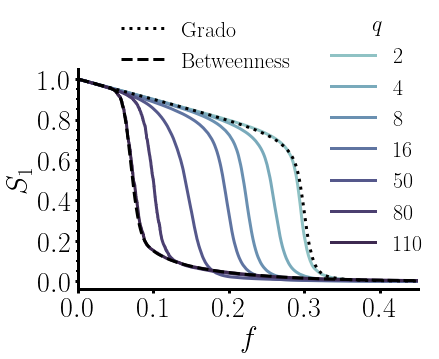

In [58]:
size = 65536
min_nseeds = 100
l_values = [
    2, 4, 8, 16, 50, 80, 110
]

colormap = sns.cubehelix_palette(
    len(l_values), 
    start=0.5, 
    rot=-0.5, 
    light=0.7, dark=0.2
)
color_dict = {f'Btw_cutoff{l}': colormap[i] for i, l in enumerate(l_values)}
base_df = load_dataframe(net_type, size, param, 'Btw', min_nseeds=min_nseeds)
deg_df = load_dataframe(net_type, size, param, 'Deg', min_nseeds=min_nseeds)
ran_df = load_dataframe(net_type, size, param, 'Ran', min_nseeds=min_nseeds)

ncols = 1
nrows = 1
fig, ax = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)
ax.set_xticks([0.0, 0.1, 0.2, 0.3, 0.4])
ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_xlabel(r'$f$')
ax.set_xlim(0, 0.45)   
ax.set_ylim(-0.04, 1.05)
ax.set_ylabel(r'$S_1$')
ax.plot(deg_df.f, deg_df.Sgcc, ':k', label=attack_dict['Deg'], zorder=100)
ax.plot(base_df.f, base_df.Sgcc, '--', color='k', label=attack_dict['Btw'], zorder=100)
#ax.plot(ran_df.f, ran_df.Sgcc, '-k', label=attack_dict['Ran'], zorder=100)
for i, l in enumerate(l_values):
    attack = f'Btw_cutoff{l}'
    df = load_dataframe(net_type, size, param, attack, min_nseeds=min_nseeds)    
    ax.plot(df.f, df.Sgcc, color=colormap[i], label=r'${{{}}}$'.format(l))

handles, labels = ax.get_legend_handles_labels()
## q-betweenness
order = range(2, len(l_values)+2)
legend1 = ax.legend(
    [handles[idx] for idx in order], [labels[idx] for idx in order],
    fontsize=22, frameon=False,
    loc=(0.72, 0.12)
)
legend1.set_title(r'$q$', prop={'size':22})
ax.add_artist(legend1)
## B and D
order = [0, 1]
ax.legend(
    [handles[idx] for idx in order], [labels[idx] for idx in order],
    fontsize=22, frameon=False, 
    #loc=(0.37, 0.85)
    loc=(0.1, 0.95)
)
sns.despine()
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'Bl_attacks')
plt.savefig(fig_name + '.png')
plt.show()

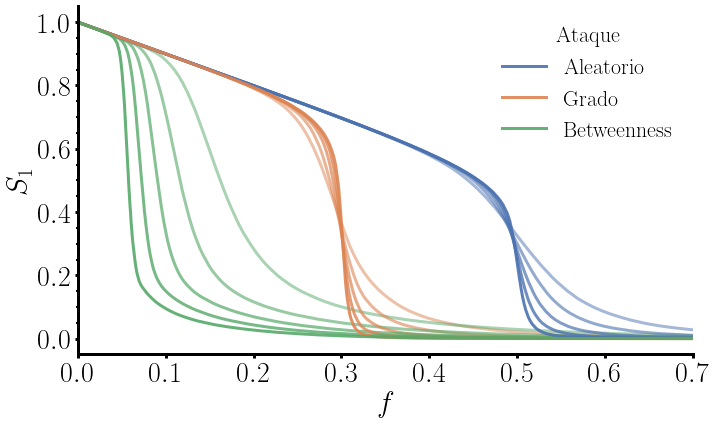

In [60]:
min_nseeds = 1000
sizes = [1024, 4096, 16384, 65536, 262144]
attacks = ['Ran', 'Deg', 'Btw']
linestyles = ['-', '-.', ':', '-', '-.']
alphas = np.arange(0.5, 1.1, 0.1)
ncols = 1
nrows = 1
fig, ax = plt.subplots(figsize=(10*ncols, 6*nrows), ncols=ncols, nrows=nrows)

ax.set_xlabel(r'$f$')
ax.set_xlim(0, 0.7)   
ax.set_ylim(-0.05, 1.05)
ax.set_ylabel(r'$S_1$')

for k, size in enumerate(sizes):
    for i, attack in enumerate(attacks):
        try:
            df = load_dataframe(net_type, size, param, attack, min_nseeds=min_nseeds)
        except:
            print(size, attack)
        L = int(np.sqrt(size))
        #label = r'${{{}}}$'.format(L) if size == sizes[-1] else ''
        label = attack_dict[attack] if size == sizes[-1] else ''
        ax.plot(
            df.f, df.Sgcc, 
            '-',
            #linestyles[k], 
            color=f'C{i}',
            alpha=alphas[k],
            label=label
        )
        
legend = ax.legend(fontsize=22, frameon=False)
legend.set_title(r'$\mathrm{Ataque}$', prop={'size':22})
sns.despine()
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'B_and_D_attacks')
plt.savefig(fig_name + '.png')
plt.show()

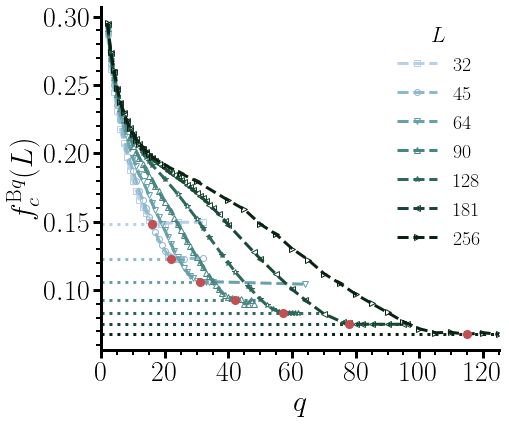

In [11]:
def fig_6a(ax):
    xlim = 1, 125
    ax.set_xlim(xlim)
    ax.set_xlabel(r'$q$')
    ax.set_ylabel(r'$f^{\mathrm{B}q}_{c}(L)$')
    ax.set_xticks(range(0, 140, 20))
    colormap = sns.cubehelix_palette(
        len(sizes), start=2, rot=0.3, light=0.8, dark=0.1
    )

    for i, size in enumerate(sizes): 
        L = np.sqrt(size)
        mask = ~np.isnan(rc_values[size][1:])

        X = l_values[mask]
        Y = rc_values[size][1:][mask]
        Y_std = rc_values_std[size][1:][mask]

        try:
            l_cutoff_idx = np.where(X == l_cutoff[size])[0][0] + 7
        except:
            l_cuotff_idx = -1

        X, Y, Y_std = X[:l_cutoff_idx], Y[:l_cutoff_idx], Y_std[:l_cutoff_idx] 

        if True:
            label = r'${{{}}}$'.format(int(L))
        else:
            label = ''
        ax.plot(X, Y, '--' + markers[i], 
                color=colormap[i],
                fillstyle='none',
                label=label
        )
        if size in l_cutoff:
            ax.axhline(
                rc_values[size][0], 0, 1.2*l_cutoff[size]/xlim[1],
                linestyle=':', color=colormap[i]
            )
        else:
            ax.axhline(
                rc_values[size][0], linestyle=':', color=colormap[i]
            )
        ax.plot(
            l_cutoff[size], rc_values[size][0], 
            'o', markersize=8, color='C3', zorder=100
        )
    legend = ax.legend(loc='best', fontsize=20, frameon=False)
    legend.set_title(r'$L$', prop={'size':22})
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='major', length=8)

sizes = [1024, 2048, 4096, 8192, 16384, 32768, 65536]
l_values = np.arange(2, 200)
nseeds = 10000
min_nseeds = 100
rc_values, rc_values_std, l_cutoff = pickle.load(open('../trefemac2021/rc_values.pickle', 'rb'))

ncols = 1
nrows = 1
fig, ax = plt.subplots(figsize=(7*ncols,6*nrows), ncols=ncols, nrows=nrows)
colormap = fig_6a(ax)
sns.despine()
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'phase_diagram_B')
plt.savefig(fig_name + '.png', transparent=False)
plt.savefig(fig_name + '.pdf')
plt.show()

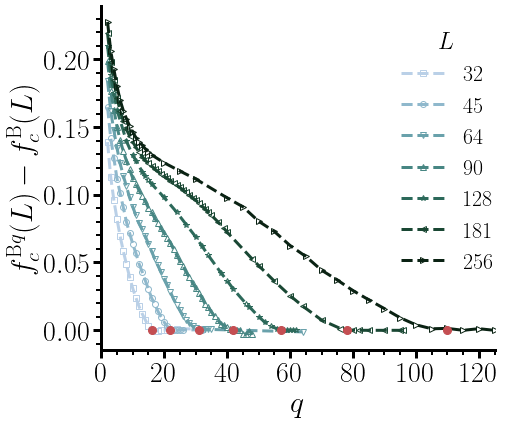

In [9]:
def fig_6a(ax):
    xlim = 1, 125
    ax.set_xlim(xlim)
    ax.set_xticks(range(0, 140, 20))
    ax.set_xlabel(r'$q$')
    ax.set_ylabel(r'$f^{\mathrm{B}q}_c(L)-f^{\mathrm{B}}_c(L)$')

    colormap = sns.cubehelix_palette(
        len(sizes), start=2, rot=0.3, light=0.8, dark=0.1
    )

    for i, size in enumerate(sizes): 
        L = np.sqrt(size)
        mask = ~np.isnan(rc_values[size][1:])

        X = l_values[mask]
        Y = rc_values[size][1:][mask] - rc_values[size][0]
        Y_std = rc_values_std[size][1:][mask]

        try:
            l_cutoff_idx = np.where(X == l_cutoff[size])[0][0] + 7
        except:
            l_cuotff_idx = -1

        X, Y, Y_std = X[:l_cutoff_idx], Y[:l_cutoff_idx], Y_std[:l_cutoff_idx] 

        if True:
            label = r'${{{}}}$'.format(int(np.sqrt(size)))
        else:
            label = ''
        ax.plot(X, Y, '--' + markers[i], 
                color=colormap[i],
                fillstyle='none',
                label=label
        )
        ax.plot(
            l_cutoff[size], 0, 
            'o', markersize=8, color='C3', zorder=100
        )
    legend = ax.legend(loc=(0.74, 0.2), fontsize=22, frameon=False)
    legend.set_title(r'$L$', prop={'size':24})
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='major', length=8)

sizes = [1024, 2048, 4096, 8192, 16384, 32768, 65536]
l_values = np.arange(2, 200)
nseeds = 10000
min_nseeds = 100
rc_values, rc_values_std, l_cutoff = pickle.load(open('../trefemac2021/rc_values.pickle', 'rb'))
l_cutoff[65536] = 110
ncols = 1
nrows = 1
fig, ax = plt.subplots(figsize=(7*ncols,6*nrows), ncols=ncols, nrows=nrows)
colormap = fig_6a(ax)
sns.despine()
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'phase_diagram_B_shifted')
plt.savefig(fig_name + '.png', transparent=False)
plt.savefig(fig_name + '.pdf')
plt.show()

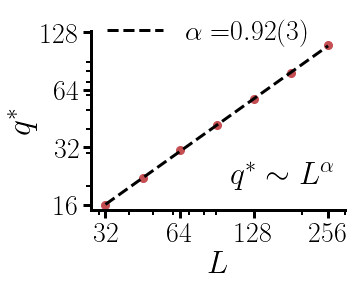

In [87]:
def plot_inset(X, Y, ax):
    axins = ax
    axins.set_xscale('log')
    axins.set_yscale('log')
    axins.plot(X, Y, 'o', color='C3', markersize=8)

    Y_pred, slope, y_err = getLinearReg(X, Y)

    c = Y_pred[-1] / X[-1]**slope
    Y_pred = powerlaw(X, slope, c)

    label = r'$\alpha = $' + r'${{{:.2f}}}({{{:.0f}}})$'.format(slope, 100*y_err)
    axins.plot(X, Y_pred, '--', color='k', label=label)
    axins.text(0.55, 0.15, r'$q^* \sim L^{\alpha}$', fontsize=32, transform=axins.transAxes)

    _c = Y_pred[-3] / X[-3]
    _Y_pred = powerlaw(X, 1, _c)

    axins.set_xlim(28, 300)
    axins.set_xticks([32, 64, 128, 256])
    axins.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
    axins.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

    axins.set_ylim(15, 130)
    axins.set_yticks([16, 32, 64, 128])
    axins.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
    axins.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    
    axins.legend(loc=(0.02, 0.85), frameon=False, fontsize=28)

    axins.set_xlabel(r'$L$', fontsize=32)
    axins.set_ylabel(r'$q^*$', fontsize=34)
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='major', length=8)
    

sizes = [1024, 2048, 4096, 8192, 16384, 32768, 65536]
l_values = np.arange(2, 200)
nseeds = 10000
min_nseeds = 100
rc_values, rc_values_std, l_cutoff = pickle.load(open('../trefemac2021/rc_values.pickle', 'rb'))
l_cutoff[65536] = 110

## Standard
X = np.sqrt(sizes)
Y = np.array([l_cutoff[size] for size in sizes])

ncols = 1
nrows = 1
fig, ax = plt.subplots(figsize=(5*ncols,4*nrows), ncols=ncols, nrows=nrows)
plot_inset(X, Y, ax)
sns.despine()
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'cutoff_scaling')
plt.savefig(fig_name + '.png', transparent=False)
plt.savefig(fig_name + '.pdf')
plt.show()

In [119]:
attack = 'Btw'

sizes = np.array([
    256, 512, 
    1024, 2048, 4096, 
    8192, 16384, 32768, 65536,131072, 262144
])
all_mean_values = []
lower_mean_values = []
upper_mean_values = []
lower_std_values = []
upper_std_values = []
all_std_values = []
nseeds_values = []
fluctuations = {}
datas = {}
for i, N in enumerate(sizes):
    try:
        delta_data, nseeds = load_delta(
            net_type, N, param, attack, min_nseeds=10, return_nseeds=True
    )
    except FileNotFoundError:
        print(N)
        raise
    datas[N] = np.array(delta_data)
    nseeds_values.append(nseeds)
    
    delta_data[:,2] = delta_data[:,2]*N
    df = pd.DataFrame(delta_data, columns=['rc', 'delta', 'N1'])
    
    mean_values = df.mean().values
    std_values = df.std().values
    
    th = 0.35
    lower_mean_values.append(df[df.delta<=th].mean().values)
    upper_mean_values.append(df[df.delta>th].mean().values)
    
    lower_std_values.append(df[df.delta<=th].std().values)
    upper_std_values.append(df[df.delta>th].std().values)
    
    all_mean_values.append(mean_values)
    all_std_values.append(std_values)
    
    
all_mean_values = np.array(all_mean_values)
lower_mean_values = np.array(lower_mean_values)
upper_mean_values = np.array(upper_mean_values)
lower_std_values = np.array(lower_std_values)
upper_std_values = np.array(upper_std_values)
all_std_values = np.array(all_std_values)
nseeds_values = np.array(nseeds_values)

rc_values = all_mean_values[:,0]
delta_values = all_mean_values[:,1]

print(sizes, rc_values, delta_values)

mean_values = {
    'all': all_mean_values[:,1],
    'lower': lower_mean_values[:,1],
    'upper': upper_mean_values[:,1]
}

std_values = {
    'all': all_std_values[:,1],
    'lower': lower_std_values[:,1],    
    'upper': upper_std_values[:,1]
}

labels = {
    'lower': r'$\mathrm{Left\;peak}$',
    'all': r'$\mathrm{All}$',
    'upper': r'$\mathrm{Right\;peak}$',
}

labels = {
    'lower': r'$\mathrm{Pico\;izquierdo}$',
    'all': r'$\mathrm{Todos}$',
    'upper': r'$\mathrm{Pico\;derecho}$',
}


[   256    512   1024   2048   4096   8192  16384  32768  65536 131072
 262144] [0.2260082  0.1839127  0.14868398 0.12307358 0.10567444 0.09316479
 0.08339266 0.07524434 0.06786433 0.06100378 0.05484166] [0.25604492 0.26970781 0.28197881 0.29040273 0.29311506 0.29372362
 0.29129794 0.2877203  0.2850116  0.28088933 0.27707431]


In [115]:
def fig_3a(ax):
    #ax.text(0.9, 0.88, letters[0], transform=ax.transAxes, fontsize=30)
    ax.text(0.9, 0.88, '(a)', transform=ax.transAxes, fontsize=30, weight='bold')
    ax.set_xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    ax.set_xlim(0.05, 0.5)
    ax.set_ylabel(r'$p(\Delta^{(i)})$')
    ax.set_xlabel(r'$\Delta^{(i)}$')
    
    _datas = {N: datas[N] for N in datas.keys() if N > 3000 and N < 140000}
    colormap = sns.cubehelix_palette(
        len(_datas), start=2, rot=0.3, light=0.8, dark=0.1
    )

    for i, (N, data) in enumerate(_datas.items()):
        _data = data[:,1] 
        freq, bin_edges = np.histogram(_data, bins=40, density=True)
        bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
        label = r'${{{}}}$'.format(int(np.sqrt(N))) 
        ax.plot(bin_centers, freq, markers[i], color=colormap[i], label=label)

    ax.axvline(0.34, color='k', linestyle=':')
    legend = ax.legend(loc=(-0.03, 0.15), fontsize=22, frameon=False)
    legend.set_title(r'$L$', prop={'size':24})

def fig_3b(ax):
    ax.text(0.04, 0.88, '(b)', transform=ax.transAxes, fontsize=30, weight='bold')
    ax.set_xlim(0.03, 0.15)
    ax.set_xticks([0.05, 0.1, 0.15, 0.2])
    ax.set_ylabel(r'$p(f_{\Delta}^{(i)})$')
    ax.set_xlabel(r'$f_{\Delta}^{(i)}$')

    _datas = {N: datas[N] for N in datas.keys() if N > 3000 and N < 140000}
    colormap = sns.cubehelix_palette(
        len(_datas), start=2, rot=0.3, light=0.8, dark=0.1
    )

    for i, (N, data) in enumerate(_datas.items()):
        _data = data[:,0]
        freq, bin_edges = np.histogram(_data, bins=40, density=True)
        bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
        label = r'${{{}}}$'.format(N)
        ax.plot(
            bin_centers, freq, 
            markers[i], 
            color=colormap[i]
        )

    bbox_to_anchor = (.52, .52, .5, .52)
    axins = inset_axes(
        ax, width="100%", height="100%",
        bbox_to_anchor=bbox_to_anchor,
        bbox_transform=ax.transAxes
    )
    axins.set_ylabel(r'$p(\phi_{\Delta}^{(i)})$')
    axins.set_xlabel(r'$\phi_{\Delta}^{(i)}$')
    axins.set_xlim(-1.1, 1.1)

    def gaussian(X, mu, sigma, c=1):
        return (c/np.sqrt(2*np.pi)*sigma)*np.exp(-0.5*((X-mu)/sigma)**2)

    for i, (N, data) in enumerate(_datas.items()):
        L = np.sqrt(N)
        _data = (data[:,0]-data[:,0].mean())*L**(0.6)
        freq, bin_edges = np.histogram(_data, bins=50, density=True)
        bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
        X = bin_centers
        Y = freq
        axins.plot(X, Y, markers[i], color=colormap[i])
        mu, sigma, c = 0, 0.2, 25
        axins.plot(X, gaussian(X, mu, sigma, c), linestyle='-', color='C8')


def fig_3c(ax):
    attack = 'Btw'
    X = np.sqrt(sizes)
    ax.text(0.9, 0.88, '(c)', transform=ax.transAxes, fontsize=30, weight='bold')
    ax.set_xscale('log')
    ax.set_ylim(0.18, 0.56)
    ax.set_xlim(26, 600)
    ax.set_xticks([32, 64, 128, 256, 512])
    ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='major', length=8)
    ax.set_xlabel(r'$L$')
    ax.set_ylabel(r'$\Delta$')

    for i, (kind, Y) in enumerate(mean_values.items()):
        ax.plot(X, Y, markers[i], markersize=10, label=labels[kind])
    ax.legend(loc=(0.05, 0.67), fontsize=22)

def fig_3e(ax):
    attack = 'Btw'
    X = np.sqrt(sizes)
    ax.text(0.9, 0.88, '(d)', transform=ax.transAxes, fontsize=30, weight='bold')
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='major', length=8)

    ax.set_xscale('log')
    ax.set_xlabel(r'$L$')
    ax.set_xlim(25, 650)
    xticks = [32, 64, 128, 256, 512]
    ax.set_xticks(xticks)
    ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

    ax.set_yscale('log')
    ax.set_ylabel(r'$f_{\Delta}\mathrm{\; and\;} \chi_{f_{\Delta}}$')

    Y = all_mean_values[:,0]# / sizes
    Y_pred, slope, y_err = getLinearReg(X[-5:], Y[-5:])
    c = Y[-1] / X[-1]**slope
    ax.plot(X, Y, markers[3], color='C3', markersize=10, label=r'$f_{\Delta}$')
    label1 = label=r'${{{:.2f}}}({{{:.0f}}})$'.format(slope, 100*y_err)
    ax.plot(
        X, powerlaw(X, slope, c), '--', color='k', 
        label=label1, zorder=-1
    )

    Y = all_std_values[:,0]#/ sizes
    Y_pred, slope, y_err = getLinearReg(X[-5:], Y[-5:])
    c = Y[-1] / X[-1]**slope
    ax.plot(X, Y, markers[4], color='C4', markersize=10, label=r'$\chi_{f_{\Delta}}$')

    label2 = label=r'${{{:.2f}}}({{{:.0f}}})$'.format(slope, 100*y_err)
    ax.plot(
        X, powerlaw(X, slope, c), '-.', color='gray', 
        label=label2, zorder=-1
    )
    ax.legend(fontsize=24, loc=(0.05, 0.9), frameon=False)

    ax.plot([0.45, 0.65], [0.78, 0.78], '-', color='k', transform=ax.transAxes)
    ax.plot([0.65, 0.65], [0.78, 0.71], '-', color='k', transform=ax.transAxes)
    ax.text(0.43, 0.82, label1, transform=ax.transAxes, fontsize=22)

    ax.plot([0.3, 0.5], [0.37, 0.37], '-', color='k', transform=ax.transAxes)
    ax.plot([0.5, 0.5], [0.37, 0.27], '-', color='k', transform=ax.transAxes)
    ax.text(0.29, 0.4, label2, transform=ax.transAxes, fontsize=22)

    handles, labels = ax.get_legend_handles_labels()
    ## Markers
    order = [0, 2]
    legend1 = ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
              fontsize=22, loc=(0.66, 0.2))

<ipython-input-116-877d0fd77c23>:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


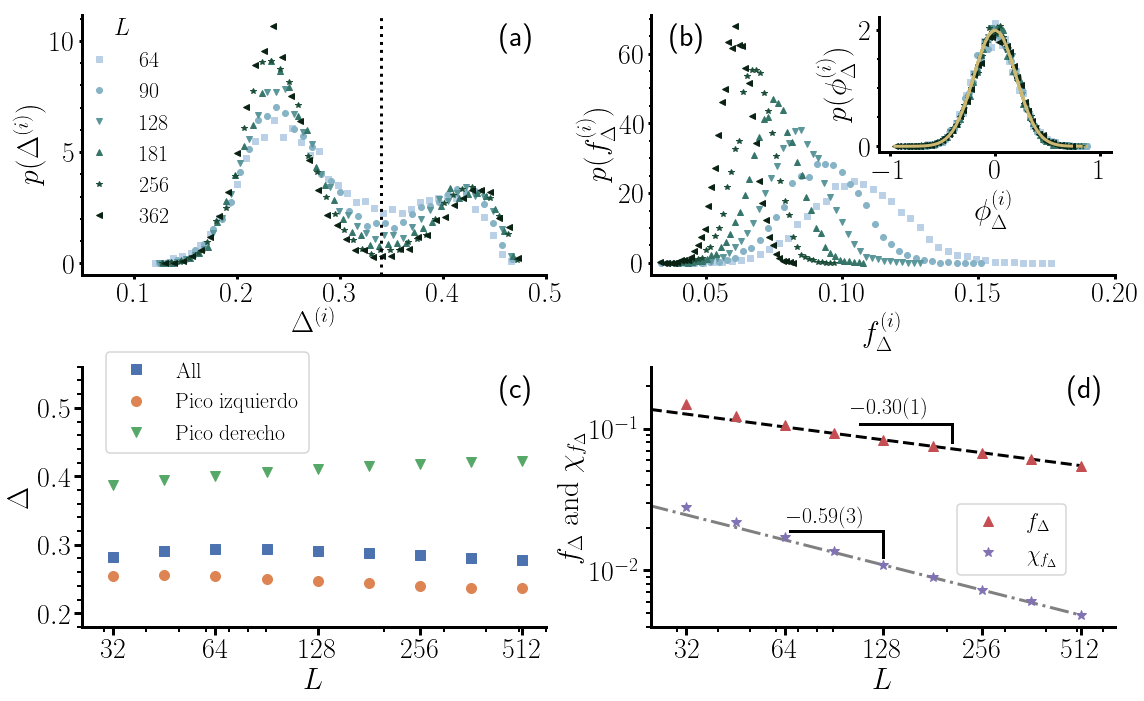

In [116]:
attack = 'Btw'
X = np.sqrt(sizes)

ncols = 2
nrows = 2
fig, axes = plt.subplots(figsize=(8*ncols, 5*nrows), ncols=ncols, nrows=nrows)

fig_3a(axes[0,0])
fig_3b(axes[0,1])
fig_3c(axes[1,0])
fig_3e(axes[1,1])

sns.despine()
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'gap_exp_scaling_B')
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')
plt.show()

<ipython-input-124-590f291abdd0>:10: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


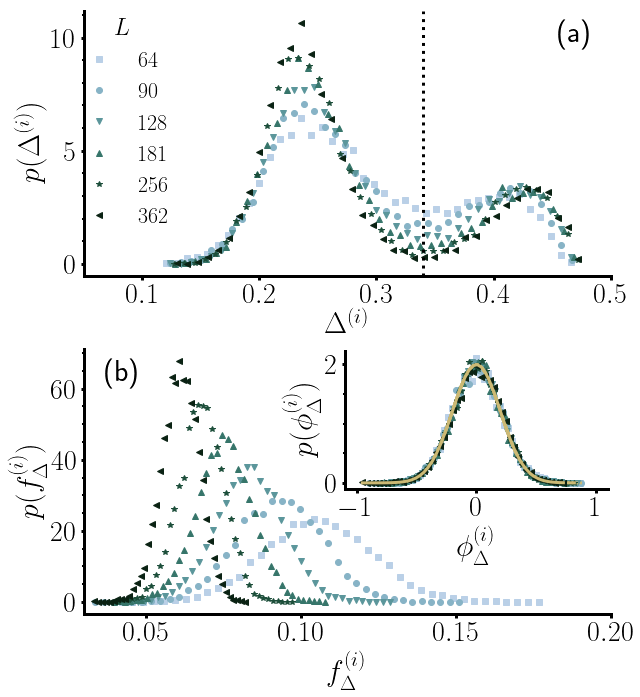

In [124]:
attack = 'Btw'
X = np.sqrt(sizes)

ncols = 1
nrows = 2
fig, axes = plt.subplots(figsize=(9*ncols, 5*nrows), ncols=ncols, nrows=nrows)
fig_3a(axes[0])
fig_3b(axes[1])
sns.despine()
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'gap_exp_scaling_B_Delta')
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')
plt.show()

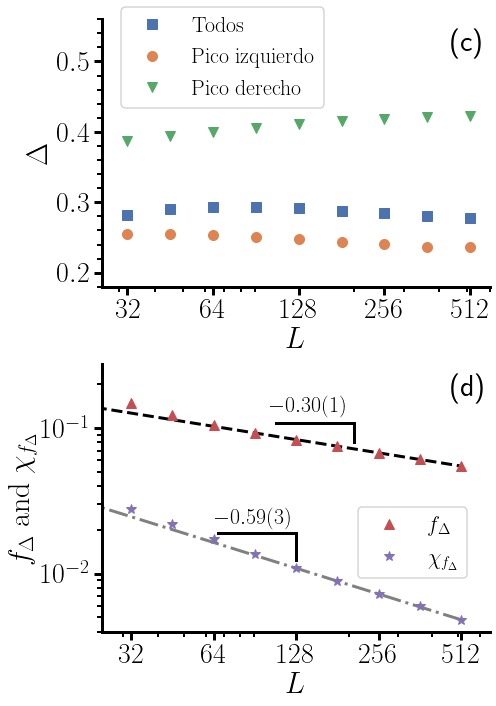

In [122]:
attack = 'Btw'
X = np.sqrt(sizes)

ncols = 1
nrows = 2
fig, axes = plt.subplots(figsize=(7*ncols, 5*nrows), ncols=ncols, nrows=nrows)
fig_3c(axes[0])
fig_3e(axes[1])
sns.despine()
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'gap_exp_scaling_B_fDelta')
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')
plt.show()

In [ ]:
measures = ['num', 'Nsec']
attack = 'Btw'

sizes = [8192, 16384, 32768, 65536, 131072]
data = {}

dfs = {}
for N in sizes:
    try:
        dfs[N] = load_dataframe(net_type, N, param, attack, min_nseeds=1000)
    except FileNotFoundError:
        continue
N_values = np.array(list(dfs.keys()))
L_values = np.sqrt(N_values)

for i, measure in enumerate(measures):
    measure_values = get_critical_measures(dfs, measure, fc='peak')
    Y_pred, slope, y_err = getLinearReg(L_values[-5:], measure_values[-5:])
    if measure == 'Nsec':
        beta_over_nu = 2 - slope
        delta_beta = y_err
    elif measure in ['num']:
        gamma_over_nu = slope
        delta_gamma = y_err    
    data[measure] = [L_values, measure_values, Y_pred, slope, y_err]

    
sizes = [
    #4096, 
    #8192, 
    16384, 
    32768, 65536, 
    131072,
    262144
]

dfs = {}
for N in sizes:
    try:
        dfs[N] = load_dataframe(net_type, N, param, attack, min_nseeds=1000)
    except FileNotFoundError:
        continue
N_values = np.array(list(dfs.keys()))
L_values = np.sqrt(N_values)

colormap = sns.cubehelix_palette(
    len(L_values), start=2, rot=0.3, light=0.8, dark=0.1
)
plot_var = False
ncols = 2
nrows = 3 if plot_var else 3
fig, axes = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)
    
for ax in axes[:,0]:
    ax.set_xlim(0, 0.35)
    ax.set_xticks([0.0, 0.1, 0.2, 0.3])
    ax.set_xlabel(r'$f$')
for ax in axes[:,1]:
    ax.set_xlim(0, 2)
    ax.set_xlabel(r'$(f-f_c) L^{1/\nu}$')

for ax in axes[:2,:].flatten():
    ax.set_xticklabels([])
    ax.set_xlabel('')
        
ax = axes[0,0]
ax.set_ylabel(r'$S_1$')
ax = axes[2,0]
ax.set_ylabel(r'$M_2$')
ax = axes[1,0]
#ax.set_ylim(-500, 17000)
#ax.set_ylim(-500, 32000)
ax.set_ylabel(r'$S_2L^2$')
if plot_var:
    ax = axes[2,0]
    ax.set_ylabel(r'$M_2$')
    
for i in [1]:
    ax = axes[0,i]
    ax.set_ylabel(r'$S_1 L^{\beta/\nu}$')
    ax = axes[2,i]
    ax.set_ylabel(r'$M_2 L^{-\gamma/\nu}$')
    ax = axes[1,i]
    ax.set_ylabel(r'$S_2 L^{\beta/\nu}$')
    if plot_var:
        ax = axes[2,i]
        ax.set_ylabel(r'$\chi L^{-\gamma/\nu}$')
        
axes[0,0].text(0.88, 0.2, '(a)', transform=axes[0,0].transAxes, fontsize=30, weight='bold')
axes[1,0].text(0.88, 0.2, '(b)', transform=axes[1,0].transAxes, fontsize=30, weight='bold')
axes[2,0].text(0.88, 0.2, '(c)', transform=axes[2,0].transAxes, fontsize=30, weight='bold')
axes[0,1].text(0.85, 0.8, '(d)', transform=axes[0,1].transAxes, fontsize=30, weight='bold')
axes[1,1].text(0.85, 0.8, '(e)', transform=axes[1,1].transAxes, fontsize=30, weight='bold')
axes[2,1].text(0.85, 0.8, '(f)', transform=axes[2,1].transAxes, fontsize=30, weight='bold')


one_over_nu = 0.58
gamma_over_nu = 2.0
beta_over_nu = 0
fc = 0.03
ax  = axes[0,1]
ax.text(0.05, 0.35, r'$f_c = {{{:.3f}}}$'.format(fc), transform=ax.transAxes, fontsize=26)
ax.text(0.05, 0.25, r'$1/\nu = {{{:.2f}}}$'.format(one_over_nu), transform=ax.transAxes, fontsize=26)
ax.text(0.05, 0.15, r'$\beta/\nu = {{{:.2f}}}$'.format(beta_over_nu), transform=ax.transAxes, fontsize=26)
ax.text(0.05, 0.05, r'$\gamma/\nu = {{{:.2f}}}$'.format(gamma_over_nu), transform=ax.transAxes, fontsize=26)
        
for i, (N, df) in enumerate(dfs.items()):
    L = np.sqrt(N)
    axes[0,0].plot(
        df.f, df.Sgcc, linestyle='', marker=markers[i], markersize=3,
        label=r'${{{}}}$'.format(N), color=colormap[i]
    )
    axes[1,0].plot(df.f, df.Nsec, linestyle='', marker=markers[i], markersize=3, color=colormap[i])
    axes[2,0].plot(df.f, df.num/N, linestyle='', marker=markers[i], markersize=3, color=colormap[i])        
        
for i, (N, df) in enumerate(dfs.items()):
    L = np.sqrt(N)

    axes[0,1].plot(
        (df.f-fc)*L**one_over_nu, df.Sgcc*N**(beta_over_nu), linestyle='', marker=markers[i], 
        markersize=3, label=r'${{{}}}$'.format(N), color=colormap[i]
    )
    axes[1,1].plot(
        (df.f-fc)*L**one_over_nu, df.Nsec*L**(beta_over_nu-2), linestyle='', 
        marker=markers[i], markersize=3, color=colormap[i]
    )
    axes[2,1].plot(
        (df.f-fc)*L**one_over_nu, df.num*L**(-gamma_over_nu)/N, linestyle='', 
        marker=markers[i], markersize=3, color=colormap[i]
    )          

legend = axes[0,0].legend(loc='upper right', fontsize=22, frameon=False)
legend.set_title(r'$L^2$', prop={'size':22})

## Insets
measures = ['Nsec', 'num']
    
bbox_to_anchor = (.52, .52, .5, .52)
axinses = []
for i in range(len(measures)):
    axins = inset_axes(
        axes[i+1,0], width="100%", height="100%",
        bbox_to_anchor=bbox_to_anchor,
        bbox_transform=axes[i+1,0].transAxes
    )
    axinses.append(axins)

axinses[0].set_ylim(2e3, 1e5)
axinses[1].set_ylim(1e3, 3e4)
for ax in axinses:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(100, 600)
    ax.set_xticks([128, 256, 512])
    ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='major', length=8)
    ax.set_xlabel(r'$L$', fontsize=22)
    ax.tick_params(axis='both', which='major', labelsize=22)
    ax.set_ylabel(r'$\mathrm{Peak\;values}$', fontsize=22)

for i, measure in enumerate(measures):
    ax = axinses[i]
    ax.set_ylabel(r'$\mathrm{Peak\;value}$', fontsize=22)
    L_values, measure_values, Y_pred, slope, y_err = data[measure]
    markers1, = ax.plot(L_values, measure_values, 'o', markersize=8)
    c = measure_values[-3] / L_values[-3]**slope
    label = r'${{{:.2f}}}({{{:.0f}}})$'.format(slope, 100*y_err)
    ax.plot(L_values, powerlaw(L_values, slope, c), '--', color='k')
    ax.plot([0.45, 0.6], [0.35, 0.35], '-', color='k', transform=ax.transAxes)
    ax.plot([0.6, 0.6], [0.35, 0.5], '-', color='k', transform=ax.transAxes)
    ax.text(0.45, 0.20, label, transform=ax.transAxes, fontsize=22)

for ax in axes.flatten():
    ax.tick_params(which='major', width=2, length=8)
    ax.tick_params(which='minor', width=1, length=4)
    
sns.despine()
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'collapse_B')
plt.savefig(fig_name + '.png')
plt.show()

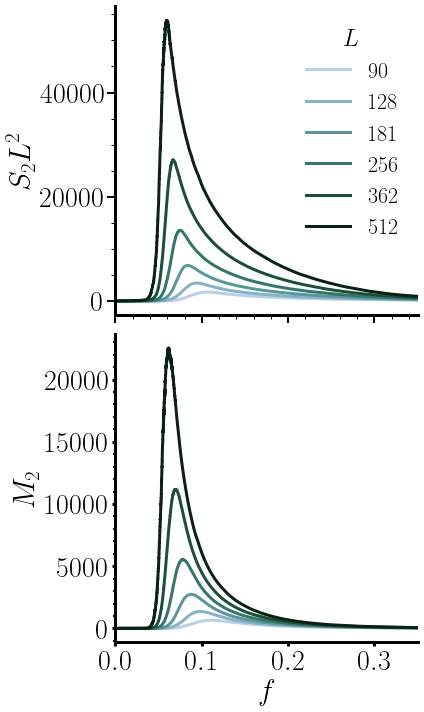

In [131]:
measures = ['num', 'Nsec']
attack = 'Btw'
    
sizes = [8192, 16384, 32768, 65536, 131072, 262144]

dfs = {}
for N in sizes:
    try:
        dfs[N] = load_dataframe(net_type, N, param, attack, min_nseeds=1000)
    except FileNotFoundError:
        continue
N_values = np.array(list(dfs.keys()))
L_values = np.sqrt(N_values)

colormap = sns.cubehelix_palette(
    len(L_values), start=2, rot=0.3, light=0.8, dark=0.1
)

ncols = 1
nrows = 2
fig, axes = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)

for ax in axes:
    ax.set_xlim(0, 0.35)
    ax.set_xticks([0.0, 0.1, 0.2, 0.3])
    ax.set_xlabel(r'$f$')

ax = axes[1]
ax.set_ylabel(r'$M_2$')
ax = axes[0]
ax.set_ylabel(r'$S_2L^2$')
ax.set_xticklabels([])
ax.set_xlabel('')
    
for i, (N, df) in enumerate(dfs.items()):
    L = int(np.sqrt(N))
    axes[0].plot(df.f, df.Nsec, linestyle='-', color=colormap[i], label=r'${{{}}}$'.format(L))
    axes[1].plot(df.f, df.num/N, linestyle='-', color=colormap[i])        
      

legend = axes[0].legend(loc='upper right', fontsize=22, frameon=False)
legend.set_title(r'$L$', prop={'size':24})


ax.tick_params(which='major', width=2, length=8)
ax.tick_params(which='minor', width=1, length=4)
    
sns.despine()
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'Nsec_and_M2_B')
plt.savefig(fig_name + '.png')
plt.show()

In [132]:
def get_histo(comp_sizes, nbins=None, log=True, density=True):
    
    if nbins is None:
        nbins = 20
    
    mask = comp_sizes > 0
    comp_sizes = comp_sizes[mask]     
    min_s = np.min(comp_sizes)
    max_s = np.max(comp_sizes)
    if log:
        bins = np.logspace(np.log10(min_s), np.log10(max_s), nbins)
    else:
        bins = np.linspace(min_s, max_s+1, nbins)
    freq, bin_edges = np.histogram(comp_sizes, bins=bins, density=density)
    freq_norm = freq.astype('float')
    freq_norm[freq_norm==0] = np.NaN
    
    freq_norm = freq_norm / np.diff(bin_edges)
    
    mask = ~np.isnan(freq_norm)
    X = bins[:-1]
    X = X[mask]
    Y = freq_norm[mask]

    return X, Y

attack = 'Btw'
sizes = [8192, 16384, 32768, 65536, 131072]
#sizes = [65536]
gcc = True

f_values_dict = {
    131072: ['0.06097', '0.06737', '0.06874'],
    65536: ['0.06786', '0.07231', '0.07579'],
    32768: ['0.07524', '0.08041', '0.08307'],
    16384: ['0.08338', '0.09088', '0.09326'],
    8192: ['0.09316', '0.10266', '0.10789']
}

all_comp_sizes = {}
nseeds_values = {}

for N in sizes:
    print(N)
    f_value = f_values_dict[N][0]
    
    net_dir_name = '../networks/DT/DT_param'.format(param)
    base_net_name = 'DT_param_N{}'.format(N)
    base_net_dir_name = os.path.join(net_dir_name, base_net_name)
    if gcc:
        comp_sizes_file = 'comp_sizes_gcc_{}_f{}.txt'.format(attack, f_value)
        seeds_file = 'comp_sizes_gcc_{}_f{}_seeds.txt'.format(attack, f_value)
    else:
        comp_sizes_file = 'comp_sizes_{}_f{}.txt'.format(attack, f_value)
        seeds_file = 'comp_sizes_{}_f{}_seeds.txt'.format(attack, f_value)
    full_comp_sizes_file = os.path.join(base_net_dir_name, comp_sizes_file)
    full_seeds_file = os.path.join(base_net_dir_name, seeds_file)
    comp_sizes = np.loadtxt(full_comp_sizes_file, dtype=int)
    nseeds = len(np.loadtxt(full_seeds_file, dtype=int))

    nseeds_values[N] = nseeds
    all_comp_sizes[N] = comp_sizes

print(nseeds_values)

8192
16384
32768
65536
131072
{8192: 10000, 16384: 1000, 32768: 1000, 65536: 10000, 131072: 1000}


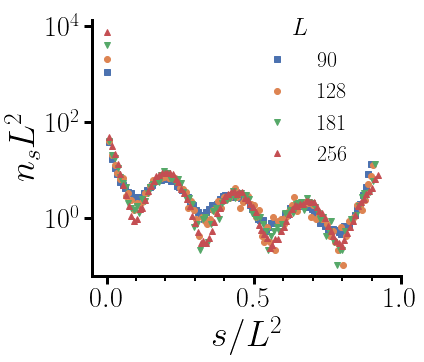

In [136]:
ncols = 1
fig, ax = plt.subplots(figsize=(6*ncols,5), ncols=ncols)

ax.tick_params(which='minor', length=5)
ax.tick_params(which='major', length=8)
ax.set_xlim(-0.05, 1)
ax.set_yscale('log')
ax.set_xlabel(r'$s/L^2$', fontsize=36)
ax.set_ylabel(r'$n_s L^2$', fontsize=36)    

for i, N in enumerate(sizes[:-1]):

    comp_sizes = all_comp_sizes[N]
    comp_sizes = comp_sizes[comp_sizes>0]
    nbins = 100   
    X, Y = get_histo(comp_sizes, nbins=nbins, log=False, density=False)
    Y = Y / nseeds_values[N] 
    
    X = X / N
    Y = Y * N 
    
    ax.plot(
        X, Y, marker=markers[i], linestyle='', 
        label=r'${{{}}}$'.format(int(np.sqrt(N)))
    ) 
legend = ax.legend(loc=(0.5, 0.4), fontsize=22, frameon=False)
legend.set_title(r'$L$', prop={'size':24})

plt.tight_layout() 
sns.despine()
fig_name = os.path.join(fig_dir, 'ns_scaled_B_linear_{}')
plt.savefig(fig_name + '.png')
plt.show()

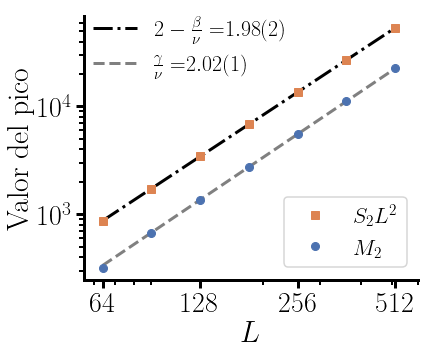

In [154]:
measures = ['num', 'Nsec']
attacks = ['Btw']

sizes = [4096, 8192, 16384, 32768, 65536, 131072, 262144]

data = {}
for k, attack in enumerate(attacks):

    data[attack] = {}
    
    dfs = {}
    for N in sizes:
        try:
            dfs[N] = load_dataframe(net_type, N, param, attack, min_nseeds=1000)
        except FileNotFoundError:
            continue
    N_values = np.array(list(dfs.keys()))
    L_values = np.sqrt(N_values)
    for i, measure in enumerate(measures):
        measure_values = get_critical_measures(dfs, measure, fc='peak')
        Y_pred, slope, y_err = getLinearReg(
            L_values[-5:], 
            measure_values[-5:],
            t=2.5
        )
        c = measure_values[-3] / L_values[-3]**slope
        data[attack][measure] = [L_values, measure_values, Y_pred, slope, y_err, c]

ncols = 1
nrows = 1
fig, axes = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)
axes = np.array(axes).reshape(-1).flatten()
for ax in axes:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(56, 600)
    ax.set_xticks([64, 128, 256, 512])
    ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='major', length=8)
    ax.set_xlabel(r'$L$')

for k, attack in enumerate(attacks):
    ax.set_ylabel(r'$\mathrm{Valor\;del\;pico}$')
    for i, measure in enumerate(measures):
        L_values, measure_values, Y_pred, slope, y_err, c = data[attack][measure]    
        if measure == 'num':
            label = r'$\frac{\gamma}{\nu} = $' + r'${{{:.2f}}}({{{:.0f}}})$'.format(slope, 100*y_err)
            label1 = label
            line1, = ax.plot(L_values, powerlaw(L_values, slope, c), '--', color='grey', label=label)
        elif measure == 'Nsec':
            label = r'$2 - \frac{\beta}{\nu} = $' + r'${{{:.2f}}}({{{:.0f}}})$'.format(slope, 100*y_err)
            label2 = label
            line2, = ax.plot(L_values, powerlaw(L_values, slope, c), '-.', color='k', label=label)
        else:
            pass

        markers1, = ax.plot(
            L_values, measure_values, marker_dict[measure], 
            color=color_dict[measure], markersize=8, 
            label=measures_dict[measure]
        )

    handles, labels = ax.get_legend_handles_labels()
    ## Markers
    order = [3, 1]
    legend1 = ax.legend(
        [handles[idx] for idx in order], [labels[idx] for idx in order],
        fontsize=22, loc=(0.6, 0.05)
    )
    ax.add_artist(legend1)
    ## Lines
    order = [2, 0]
    ax.legend(
        [handles[idx] for idx in order], [labels[idx] for idx in order],
        fontsize=22, loc=(0.0, 0.73), frameon=False
    )

sns.despine()
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'beta_gamma_nu_scaling_B')
plt.savefig(fig_name + '.png')
plt.show()

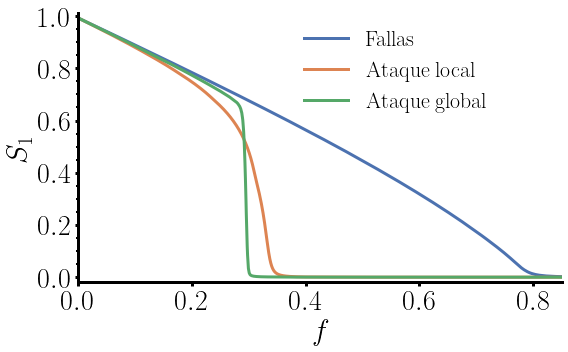

In [184]:
min_nseeds = 1000
sizes = [
    #250, 1000, 4000, 
    16000
]
attacks = ['Ran', 'DegU', 'BtwU']
linestyles = ['-', '-.', ':', '-', '-.']
ncols = 1
nrows = 1
fig, ax = plt.subplots(figsize=(8*ncols, 5*nrows), ncols=ncols, nrows=nrows)

ax.set_xlabel(r'$f$')
ax.set_xlim(0, 0.85)   
ax.set_yticks(np.arange(0, 1.1, 0.2))
ax.set_ylim(-0.02, 1.01)
ax.set_ylabel(r'$S_1$')

labels = [
    r'$\mathrm{Fallas}$',
    r'$\mathrm{Ataque\;local}$',
    r'$\mathrm{Ataque\;global}$'
]

for k, size in enumerate(sizes):
    for i, attack in enumerate(attacks):
        try:
            df = load_dataframe('ER', size, '5.00', attack, min_nseeds=min_nseeds)
        except:
            print(size, attack)
        L = int(np.sqrt(size))
        ax.plot(df.f, df.Sgcc, '-', color=f'C{i}', label=labels[i])
ax.legend(fontsize=22, frameon=False, loc=(0.45, 0.6))

sns.despine()
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'B_and_D_attacks_ER')
plt.savefig(fig_name + '.png')
plt.show()

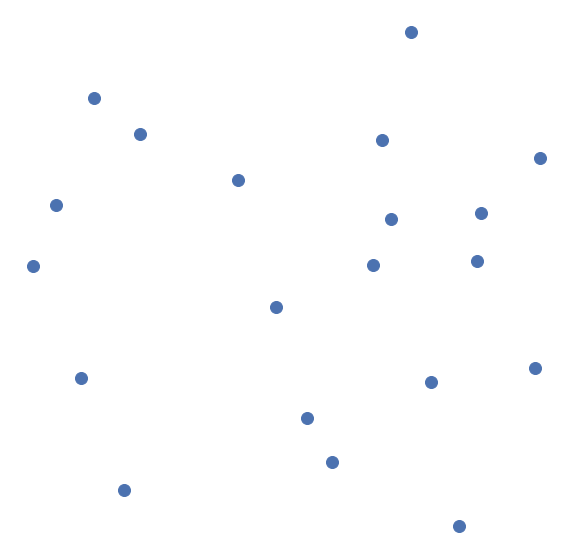

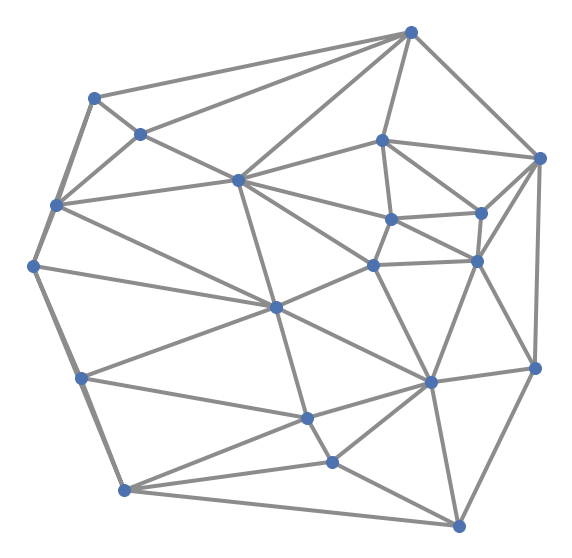

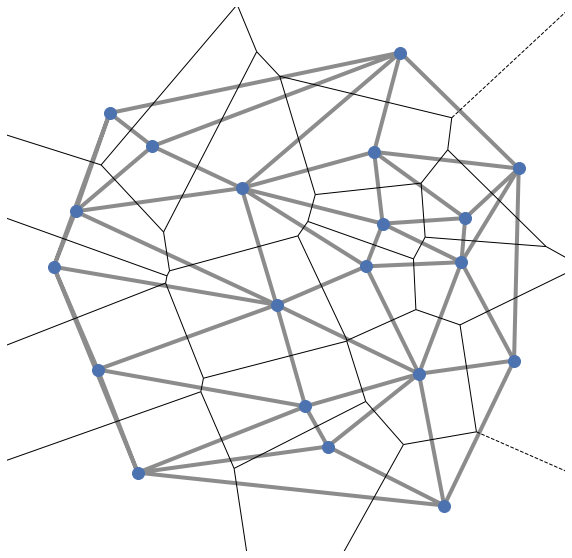

In [45]:
from robustness.planar import create_points
from scipy.spatial import Delaunay, Voronoi, voronoi_plot_2d
def plot_delaunay(N, seed=None, plot_points=True, plot_tri=True, plot_vor=False):
    points = create_points(N, random_seed=random_seed)
    tri = Delaunay(points)
    vor = Voronoi(points)
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_xticks([])
    ax.set_yticks([])
    
    fig_name = 'delaunay_plot'
    if plot_points:
        ax.plot(points[:,0], points[:,1], 'o', color='C0', markersize=12)
        fig_name += '_points'
    if plot_tri:
        ax.triplot(points[:,0], points[:,1], tri.simplices, color='C7', linewidth=4)
        fig_name += '_tri'
    if plot_vor:
        voronoi_plot_2d(vor, ax=ax, show_vertices=False)
        fig_name += '_vor'
    sns.despine(bottom=True, left=True)
    plt.savefig(os.path.join(fig_dir, f'{fig_name}.png'))
    plt.show()
    
N = 20
random_seed = 10
plot_delaunay(N, seed=random_seed, plot_points=True, plot_tri=False, plot_vor=False)
plot_delaunay(N, seed=random_seed, plot_points=True, plot_tri=True, plot_vor=False)
plot_delaunay(N, seed=random_seed, plot_points=True, plot_tri=True, plot_vor=True)

In [35]:
vor.regions[0]

[4, -1, 0, 1, 3]

In [39]:
vor.regions[0]

[4, -1, 0, 1, 3]

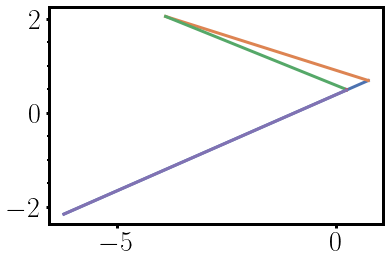

In [40]:
region = vor.regions[0]
for i in range(len(region)):
    start = region[i]
    finish = region[(i+1)%len(region)]
    X = [vor.vertices[start][0], vor.vertices[finish][0]]
    Y = [vor.vertices[start][1], vor.vertices[finish][1]]
    plt.plot(X, Y, '-')


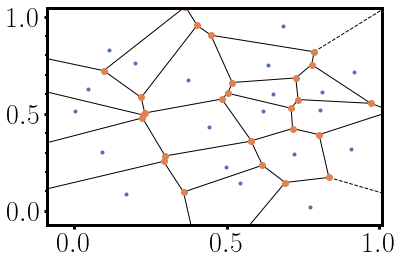

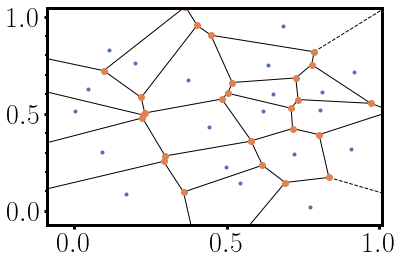

In [29]:
vor = Voronoi(points)
